In [1]:
%matplotlib widget

In [36]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, ListedColormap, to_rgb
import matplotlib.patheffects as PathEffects
from astropy.table import Table
from astropy.cosmology import Planck18_arXiv_v2 as cosmo
import astropy.units as u
import cmocean

def ax_bothticks(ax):
    ax.xaxis.set_ticks_position("both")
    ax.yaxis.set_ticks_position("both")
    
def cmap_from_colors(col_list):
    x = np.arange(256)
    n = len(col_list)
    rgb_list = np.array([to_rgb(col) for col in col_list])
    x_list = np.linspace(0.0, 255.0, n)
    rgb_interp = np.array(
        [interp1d(x_list, rgb_list[:, i], kind="linear")(x) for i in range(3)]
    )
    return ListedColormap(rgb_interp.T)


In [15]:
psz2 = Table.read("./PSZ2.dat", format="ascii")
act = Table.read("./ACT_DR5.fits")
spt_ecs = Table.read("./SPT-ECS.fits")
spt_sz = Table.read("./SPT-sz.fits")
my_sample = Table({"name": [f"C{i}" for i in range(1, 4)], "z": [0.05, 0.5, 1.0], "M500": [9e14, 5e14, 3e14]})

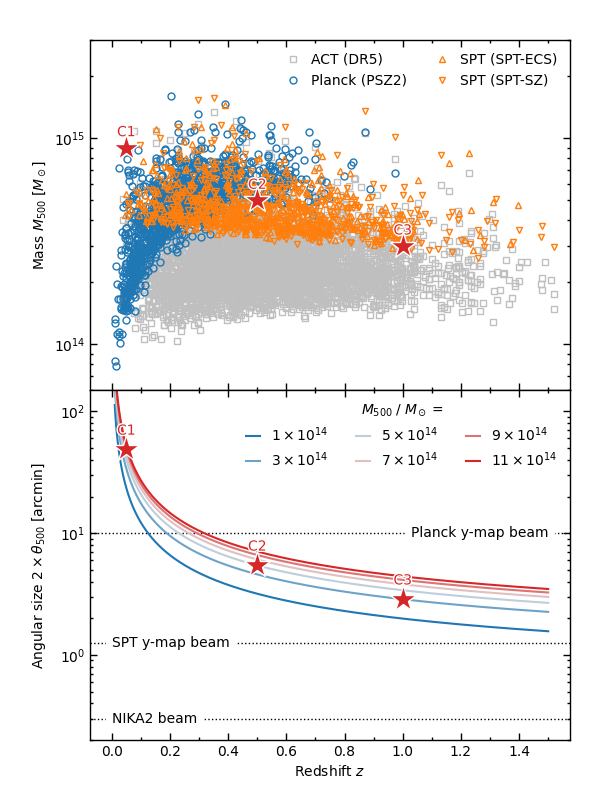

In [58]:
plt.close("all")
fig, axs = plt.subplots(2, 1, figsize=(6, 8))

kw = {"ms": 5, "mfc": "#00000000"}

ax = axs[0]

ax.plot(act["redshift"].data, act["M500"].data * 1e14, "s", mec="0.75", label="ACT (DR5)", **kw)
ax.plot(psz2["redshift"].data, psz2["mass_sz"].data * 1e14, "o", mec="tab:blue", label="Planck (PSZ2)", **kw)
ax.plot(spt_ecs["REDSHIFT"].data, spt_ecs["M500"].data * 1e14, "^", mec="tab:orange", label="SPT (SPT-ECS)", **kw)
ax.plot(spt_sz["REDSHIFT"].data, spt_sz["M500"].data * 1e14, "v", mec="tab:orange", label="SPT (SPT-SZ)", **kw)

for cl in my_sample:
    ax.plot(cl["z"], cl["M500"], "*", color="tab:red", ms=20, mec="w", zorder=20)
    txt = ax.text(
        cl["z"], 1.1*cl["M500"], cl["name"], ha="center", va="bottom", color="tab:red", zorder=19,
        #backgroundcolor="#FFFFFF88"
    )
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])

ax.set_ylabel("Mass $M_{500} \; [M_\odot]$")
ax.set_ylim(6e13, 3e15)
ax.legend(frameon=False, ncol=2, handlelength=1.0)
ax.set_xticklabels([])




ax = axs[1]
z_range = np.linspace(0.01, 1.5, 1000)

def m500_to_theta500(m500, z):
    r500 = ((3 * m500) / (4 * np.pi * 500 * cosmo.critical_density(z))) ** (1/3)
    r500 = r500.to("Mpc")
    d_a = cosmo.angular_diameter_distance(z).to("Mpc")
    theta500 = np.arctan((r500 / d_a).value) * u.rad.to("arcmin")
    return theta500

masses = np.arange(1, 12, 2)
norm = Normalize(vmin=masses.min(), vmax=masses.max())
#cmap = cmocean.tools.crop_by_percent(cmocean.cm.matter_r, 10, which='max', N=None) #plt.get_cmap("magma")
cmap = cmap_from_colors(["tab:blue", "0.9", "tab:red"])

def axhline(x, y, label, ax, zorder=10):
    ax.axhline(y, 0, 1, color="k", ls=":", zorder=zorder - 1)
    ax.text(
        x, y, label, 
        ha="right" if x > 1 else "left", va="center", backgroundcolor="w", zorder=zorder
    )

axhline(z_range.max(), 10., r"Planck y-map beam", ax, zorder=-10)
axhline(0.0, 1.25, "SPT y-map beam", ax, zorder=-10)
axhline(0.0, 18./60., "NIKA2 beam", ax, zorder=-10)

for i, m500 in enumerate(masses):
    theta500 = m500_to_theta500(m500 * 1e14 * u.Msun, z_range)
    ax.plot(z_range, 2 * theta500, color=cmap(norm(m500)), lw=1.5, zorder=1,
            #label="$M_{500} = " + f"{m:.0f}" + r" \times 10^{14} \; M_\odot$")
            label=f"${m500:.0f}" + r" \times 10^{14}$")
    
for cl in my_sample:
    theta500 = m500_to_theta500(cl["M500"] * u.Msun, cl["z"])
    ax.plot(cl["z"], 2 * theta500, "*", color="tab:red", ms=20, mec="w", zorder=20)
    txt = ax.text(
        cl["z"], 2.5*theta500, cl["name"], ha="center", va="bottom",
        color="tab:red", zorder=19
    )
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='w')])
    
ax.set_ylim(0.2, 150)
ax.set_xlabel(r"Redshift $z$")
ax.set_ylabel(r"Angular size $2 \times \theta_{500}$ [arcmin]")
ax.legend(
    frameon=False, ncol=3, handlelength=1.0,
    title=r"$M_{500} \; / \; M_\odot =$",
)


for ax in axs:
    ax.set_yscale("log")
    ax.set_xticks(np.arange(0.0, 2.1, 0.2))
    ax.set_xticks(np.arange(0.1, 2.0, 0.2), minor=True)
    ax.set_xlim(-0.075, 1.575)
    ax_bothticks(ax)

fig.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.075, hspace=0)
fig.align_labels()
fig.savefig("./validation_sample.pdf")